In [196]:
import json

import agama
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gc_utils import iteration_name, snapshot_name  # type: ignore

Lets look at disk shocking

In [197]:
sim = "m12i"

data_dir = "/Users/z5114326/Documents/GitHub/gc_statistics/data/"
data_file = data_dir + "m12i_time_dep.json"

sim_dir = "/Users/z5114326/Documents/simulations/"
pot_dir = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/potentials/"
potential_snaps = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/external/potentials.json"

fire_dir = sim_dir + sim + "/" + sim + "_res7100/"

proc_file = sim_dir + sim + "/" + sim + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

pub_data = sim_dir + "snapshot_times_public.txt"

agama.setUnits(mass=1, length=1, velocity=1)

with open(data_file, "r") as file:
    data_dict = json.load(file)

with open(potential_snaps) as json_file:
    pot_data = json.load(json_file)

snap_time_pub = pd.read_table(pub_data, comment="#", header=None, sep=r"\s+")
snap_time_pub.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

res_df = snap_time_pub[snap_time_pub["index"].isin(pot_data[sim])].reset_index(drop=True)

In [198]:
# gc_id, t_init, t_final, proc_data, pot_data

it = 0
it_id = iteration_name(it)

t_step = 0.050  # Gyr (50 Myr)

src_data = proc_data[it_id]["source"]
mask = np.array(src_data["analyse_flag"]) == 1

gc_id = 59574565

In [199]:
# idx = np.where(np.array(proc_data[it_id]["source"]["group_id"]) == 3159643)[0][0]
# gc_id = proc_data[it_id]["source"]["gc_id"][idx]
# gc_id

# idx = np.where(np.array(proc_data[it_id]["source"]["group_id"]) == 0)[0][-1]
# gc_id = proc_data[it_id]["source"]["gc_id"][idx]
# gc_id

# gc_id = 104626395

In [200]:
idx = np.where(src_data["gc_id"][mask] == gc_id)[0][0]

group_id = src_data["group_id"][mask][idx]

if group_id == 0:
    t_init = src_data["form_time"][mask][idx]
else:
    t_init = src_data["t_acc"][mask][idx]

t_early = res_df["time_Gyr"].iloc[0]

if t_init < t_early:
    t_init = t_early

t_final = src_data["t_dis"][mask][idx]
t_late = res_df["time_Gyr"].iloc[-1]

if t_final == -1:
    t_final = t_late

In [201]:
# find value in t_list closest to t_early

t_list = res_df["time_Gyr"]

tim_start = res_df["time_Gyr"][(t_list - t_init).abs().idxmin()]
if tim_start < t_init:
    pot_start = res_df["index"][(t_list - t_init).abs().idxmin() + 1]
else:
    pot_start = res_df["index"][(t_list - t_init).abs().idxmin()]


tim_end = res_df["time_Gyr"][(t_list - t_final).abs().idxmin()]
if tim_end > t_final:
    pot_end = res_df["index"][(t_list - t_final).abs().idxmin() - 1]
else:
    pot_end = res_df["index"][(t_list - t_final).abs().idxmin()]

    # need to check for the time issue in the GC model output
    snap_id = snapshot_name(pot_end)
    idx_check = np.where(np.array(proc_data["it000"]["snapshots"][snap_id]["gc_id"]) == gc_id)[0]
    if len(idx_check) == 0:
        pot_end = res_df["index"][(t_list - t_final).abs().idxmin() - 1]

# t_start = filtered_df["time_Gyr"][idx_start]

df = res_df[(res_df["index"] >= pot_start) & (res_df["index"] <= pot_end)].reset_index(drop=True)

In [202]:
if len(df) > 1:
    pot_dict = {}
    pot_dict[df["index"][0]] = {}
    pot_dict[df["index"][0]]["t0"] = t_init

    # pot_dict[df["index"][0]]["t1"] = df["time_Gyr"][0]
    pot_dict[df["index"][0]]["t1"] = np.max([df["time_Gyr"][0], t_init])

    t_hold = df["time_Gyr"][0] + (df["time_Gyr"][1] - df["time_Gyr"][0]) / 2
    pot_dict[df["index"][0]]["t2"] = t_hold

    # n01 = int(np.round((pot_dict[df["index"][0]]["t1"] - pot_dict[df["index"][0]]["t0"]) / t_step))
    # n12 = int(np.round((pot_dict[df["index"][0]]["t2"] - pot_dict[df["index"][0]]["t1"]) / t_step))

    # pot_dict[df["index"][0]]["n01"] = n01
    # pot_dict[df["index"][0]]["n12"] = n12

    for i in range(2, len(df["time_Gyr"])):
        pot_dict[df["index"][i - 1]] = {}

        t_past = df["time_Gyr"][i - 1]
        t_futu = df["time_Gyr"][i]

        t_hold = t_past + (t_futu - t_past) / 2

        pot_dict[df["index"][i - 1]]["t0"] = pot_dict[df["index"][i - 2]]["t2"]
        pot_dict[df["index"][i - 1]]["t1"] = df["time_Gyr"][i - 1]
        pot_dict[df["index"][i - 1]]["t2"] = t_hold

        # n01 = int(np.round((pot_dict[df["index"][i - 1]]["t1"] - pot_dict[df["index"][i - 1]]["t0"]) / t_step))
        # n12 = int(np.round((pot_dict[df["index"][i - 1]]["t2"] - pot_dict[df["index"][i - 1]]["t1"]) / t_step))

        # pot_dict[df["index"][i - 1]]["n01"] = n01
        # pot_dict[df["index"][i - 1]]["n12"] = n12

    pot_dict[df["index"].iloc[-1]] = {}

    t0 = pot_dict[df["index"].iloc[-2]]["t2"]
    pot_dict[df["index"].iloc[-1]]["t0"] = t0
    pot_dict[df["index"].iloc[-1]]["t1"] = np.min([df["time_Gyr"].iloc[-1], t_final])
    pot_dict[df["index"].iloc[-1]]["t2"] = t_final

    # n01 = int(np.round((pot_dict[df["index"].iloc[-1]]["t1"] - pot_dict[df["index"].iloc[-1]]["t0"]) / t_step))
    # n12 = int(np.round((pot_dict[df["index"].iloc[-1]]["t2"] - pot_dict[df["index"].iloc[-1]]["t1"]) / t_step))

    # pot_dict[df["index"].iloc[-1]]["n01"] = n01
    # pot_dict[df["index"].iloc[-1]]["n12"] = n12

else:
    pot_dict = {}
    pot_dict[df["index"][0]] = {}
    pot_dict[df["index"][0]]["t0"] = t_init

    pot_dict[df["index"][0]]["t1"] = (t_init + t_final) / 2

    pot_dict[df["index"][0]]["t2"] = t_final

In [203]:
# find nearest
def propagate(init_cond, t_prop_from, t_prop_to, t_step, pot_nbody):
    dt = t_prop_to - t_prop_from

    # Floor ensures step size ≤ t_step
    num_steps = max(int(np.abs(np.floor(dt / t_step))), 1) + 1
    # num_steps = 1000

    time, posvel = agama.orbit(potential=pot_nbody, ic=init_cond, time=dt, trajsize=num_steps)

    time = t_prop_from + time

    return time, posvel


In [204]:
time_arr = np.array([])
posvel_arr = np.empty((0, 6))  # 2D with 6 columns (same as posvel)

for snap in pot_dict:
    potential_file = pot_dir + sim + "/snap_%d/combined_snap_%d.ini" % (snap, snap)

    pot_nbody = agama.Potential(potential_file)

    t0 = pot_dict[snap]["t0"]
    t1 = pot_dict[snap]["t1"]
    t2 = pot_dict[snap]["t2"]

    snap_id = snapshot_name(snap)
    snap_data = proc_data[it_id]["snapshots"][snap_id]

    print(snap_id)

    idx = np.where(np.array(snap_data["gc_id"]) == gc_id)[0][0]

    x = snap_data["x"][idx]
    y = snap_data["y"][idx]
    z = snap_data["z"][idx]

    vx = snap_data["vx"][idx]
    vy = snap_data["vy"][idx]
    vz = snap_data["vz"][idx]

    init_cond = [x, y, z, vx, vy, vz]

    # propagate backwards
    time, posvel = propagate(init_cond, t1, t0, t_step, pot_nbody)

    # Get sorted indices
    sorted_indices = np.argsort(time)

    # sort by ascending order
    time = time[sorted_indices]
    posvel = posvel[sorted_indices]

    # stack arrays
    if snap == df["index"][0]:
        time_arr = np.concatenate((time_arr, time))
        posvel_arr = np.vstack((posvel_arr, posvel))
    else:
        time_arr = np.concatenate((time_arr, time[1:]))
        posvel_arr = np.vstack((posvel_arr, posvel[1:]))

    # propagate forwards
    time, posvel = propagate(init_cond, t1, t2, t_step, pot_nbody)

    # stack arrays (don't include first inputs as repetition)
    time_arr = np.concatenate((time_arr, time[1:]))
    posvel_arr = np.vstack((posvel_arr, posvel[1:]))


snap486
snap534
snap590
snap591
snap592
snap593
snap594
snap595
snap596
snap597
snap598
snap599
snap600


In [205]:
src_dat = proc_data["it000"]["source"]
idx = np.where(np.array(src_dat["gc_id"]) == gc_id)[0][0]
idx

src_dat["t_dis"][idx]

-1.0

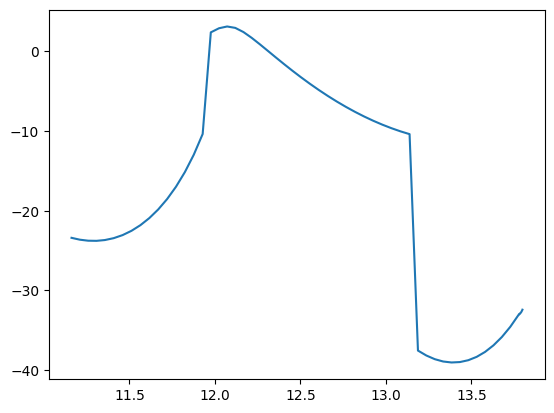

In [206]:
z_arr = posvel_arr[:, 2]
plt.plot(time_arr, z_arr)

In [207]:
df

,index,scale_factor,redshift,time_Gyr,lookback_time_Gyr,time_width_Myr
0,486,0.832802,0.200765,11.355789,2.442958,24.3311
1,534,0.909236,0.099825,12.500601,1.298146,23.3771
2,590,0.998408,0.001595,13.776556,0.022190,22.2097
3,591,0.998567,0.001435,13.778778,0.019969,2.2211
4,592,0.998726,0.001276,13.780997,0.017750,2.2193
5,593,0.998885,0.001116,13.783217,0.015530,2.2199
6,594,0.999045,0.000956,13.785436,0.013311,2.2189
7,595,0.999204,0.000797,13.787654,0.011093,2.2186
8,596,0.999363,0.000637,13.789874,0.008872,2.2201
9,597,0.999522,0.000478,13.792093,0.006654,2.2182


In [208]:
pot_dict

{486: {'t0': 11.161, 't1': 11.355789171, 't2': 11.9281951635},
 534: {'t0': 11.9281951635, 't1': 12.500601156, 't2': 13.138578806},
 590: {'t0': 13.138578806, 't1': 13.776556456, 't2': 13.7776670295},
 591: {'t0': 13.7776670295, 't1': 13.778777603, 't2': 13.779887241},
 592: {'t0': 13.779887241, 't1': 13.780996879, 't2': 13.782106828},
 593: {'t0': 13.782106828, 't1': 13.783216777, 't2': 13.784326206},
 594: {'t0': 13.784326206, 't1': 13.785435635, 't2': 13.7865449595},
 595: {'t0': 13.7865449595, 't1': 13.787654284, 't2': 13.788764334},
 596: {'t0': 13.788764334, 't1': 13.789874384, 't2': 13.790983499500001},
 597: {'t0': 13.790983499500001, 't1': 13.792092615, 't2': 13.7932012105},
 598: {'t0': 13.7932012105, 't1': 13.794309806, 't2': 13.795419543},
 599: {'t0': 13.795419543, 't1': 13.79652928, 't2': 13.7976380815},
 600: {'t0': 13.7976380815, 't1': 13.798746883, 't2': 13.798746883}}